In [4]:
%pip install openassetpricing

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_stock = pd.read_stata("Data/CRSP Universe Monthly Stock File 1960-2018.dta")

In [4]:
df_stock.columns

Index(['permno', 'date', 'nameendt', 'shrcd', 'exchcd', 'siccd', 'ncusip',
       'ticker', 'comnam', 'shrcls', 'tsymbol', 'naics', 'primexch', 'trdstat',
       'secstat', 'permco', 'issuno', 'hexcd', 'hsiccd', 'cusip', 'dclrdt',
       'dlamt', 'dlpdt', 'dlstcd', 'nextdt', 'paydt', 'rcrddt', 'shrflg',
       'hsicmg', 'hsicig', 'distcd', 'divamt', 'facpr', 'facshr', 'acperm',
       'accomp', 'shrenddt', 'nwperm', 'dlretx', 'dlprc', 'dlret', 'trtscd',
       'nmsind', 'mmcnt', 'nsdinx', 'bidlo', 'askhi', 'prc', 'vol', 'ret',
       'bid', 'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread',
       'altprcdt', 'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

In [5]:
df_stock['date'] = pd.to_datetime(df_stock["date"], format="%Y%m")
df_stock['date'] = df_stock['date'].dt.strftime('%Y-%m')


In [6]:
df_stock["permno"] = df_stock["permno"].astype(int)

In [7]:
import openassetpricing as oap

In [8]:
oap.list_release()

┌───────────┐
│   Release │
├───────────┤
│      2022 │
│      2023 │
│    202408 │
│    202410 │
└───────────┘


In [9]:
openap = oap.OpenAP(202410)

In [10]:
df_bm = openap.dl_signal('pandas', ['BM'])


Data is downloaded: 17s


In [11]:

df_bm["date"] = pd.to_datetime(df_bm["yyyymm"].astype(str), format='%Y%m')
df_bm["date"] = df_bm["date"].dt.strftime("%Y-%m")

In [12]:
df = pd.merge(df_stock, df_bm, left_on=["permno", "date"], right_on=["permno", "date"], how="inner")

„Beobachtungen mit einem cfacpr- oder cfacshr-Wert von 0 wurden im Rahmen der Datenbereinigung auf den Wert 1 gesetzt. Dies erfolgt unter der Annahme, dass in diesen Fällen keine Kapitalmaßnahmen vorlagen, die eine Preis- oder Stückzahladjustierung erforderlich gemacht hätten.“

In [13]:
df['cfacpr'] = df['cfacpr'].replace(0, 1)
df['cfacshr'] = df['cfacshr'].replace(0, 1)

df["adj_price"] = df["altprc"].abs() / df["cfacpr"]
df["adj_shrout"] = df["shrout"] * df["cfacshr"]
df["adj_dividend"] = df["dlamt"] / df["cfacpr"]

In [14]:
df[df['cfacpr'] == 0][['permno', 'date', 'prc', 'cfacpr']]
df.columns


Index(['permno', 'date', 'nameendt', 'shrcd', 'exchcd', 'siccd', 'ncusip',
       'ticker', 'comnam', 'shrcls', 'tsymbol', 'naics', 'primexch', 'trdstat',
       'secstat', 'permco', 'issuno', 'hexcd', 'hsiccd', 'cusip', 'dclrdt',
       'dlamt', 'dlpdt', 'dlstcd', 'nextdt', 'paydt', 'rcrddt', 'shrflg',
       'hsicmg', 'hsicig', 'distcd', 'divamt', 'facpr', 'facshr', 'acperm',
       'accomp', 'shrenddt', 'nwperm', 'dlretx', 'dlprc', 'dlret', 'trtscd',
       'nmsind', 'mmcnt', 'nsdinx', 'bidlo', 'askhi', 'prc', 'vol', 'ret',
       'bid', 'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread',
       'altprcdt', 'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn',
       'yyyymm', 'BM', 'adj_price', 'adj_shrout', 'adj_dividend'],
      dtype='object')

ETF contained


Vorgehen

- log returns berechnen
- log(Pt+/Bt+) - log(Pt-1/Bt-1)  --> Change in aggregate valuation
- log(Bt-/Bt-1) - log(Dt-/Pt-)   --> Income Yield
- log(Pt-/Bt-) - log(Pt+/Bt+)    --> Migration

Price --> altprc


Probleme

- Werte Pt- und Bt- korrekt zu bestimmen!

In [15]:
print(df.columns)

Index(['permno', 'date', 'nameendt', 'shrcd', 'exchcd', 'siccd', 'ncusip',
       'ticker', 'comnam', 'shrcls', 'tsymbol', 'naics', 'primexch', 'trdstat',
       'secstat', 'permco', 'issuno', 'hexcd', 'hsiccd', 'cusip', 'dclrdt',
       'dlamt', 'dlpdt', 'dlstcd', 'nextdt', 'paydt', 'rcrddt', 'shrflg',
       'hsicmg', 'hsicig', 'distcd', 'divamt', 'facpr', 'facshr', 'acperm',
       'accomp', 'shrenddt', 'nwperm', 'dlretx', 'dlprc', 'dlret', 'trtscd',
       'nmsind', 'mmcnt', 'nsdinx', 'bidlo', 'askhi', 'prc', 'vol', 'ret',
       'bid', 'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread',
       'altprcdt', 'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn',
       'yyyymm', 'BM', 'adj_price', 'adj_shrout', 'adj_dividend'],
      dtype='object')


Here’s a breakdown of the columns you've listed from the CRSP stock data:

permno:
Description: Unique permanent identifier for each stock in the CRSP database.
Type: Integer.
date:
Description: The date for the data point (typically monthly).
Type: DateTime (monthly).
nameendt:
Description: The end date for the stock's name (can be relevant for name changes).
Type: DateTime.
shrcd:
Description: Share code that identifies the type of shares (e.g., common, preferred).
Type: Integer.
exchcd:
Description: Exchange code (e.g., NYSE, NASDAQ).
Type: Integer.
siccd:
Description: Standard Industrial Classification code, representing the industry of the firm.
Type: Integer.
ncusip:
Description: The company's CUSIP identifier (unique identifier for the company).
Type: String.
ticker:
Description: Ticker symbol used for stock trading.
Type: String.
comnam:
Description: Company name.
Type: String.
shrcls:
Description: Share class code (indicating different types of shares).
Type: Integer.
tsymbol:
Description: Stock's trading symbol.
Type: String.
naics:
Description: North American Industry Classification System code.
Type: Integer.
primexch:
Description: The primary exchange where the stock is listed.
Type: Integer.
trdstat:
Description: Trading status (active, inactive, etc.).
Type: Integer.
secstat:
Description: Security status (e.g., listed, delisted).
Type: Integer.
permco:
Description: Unique identifier for the company (distinct from permno, which is stock-specific).
Type: Integer.
issuno:
Description: The number of the issue (different from the company, which might have multiple issues).
Type: Integer.
hexcd:
Description: The exchange code for the stock.
Type: Integer.
hsiccd:
Description: A code that categorizes the industry sector (from SIC codes).
Type: Integer.
cusip:
Description: CUSIP identifier for the stock.
Type: String.
dclrdt:
Description: The date the dividend was declared.
Type: DateTime.
dlamt:
Description: The dividend amount declared.
Type: Float.
dlpdt:
Description: The date the dividend was paid.
Type: DateTime.
dlstcd:
Description: The code for the dividend status (paid, etc.).
Type: Integer.
nextdt:
Description: The date for the next dividend or relevant corporate action.
Type: DateTime.
paydt:
Description: The payment date for dividends.
Type: DateTime.
rcrddt:
Description: The record date for the dividend or corporate action.
Type: DateTime.
shrflg:
Description: Flag indicating the share structure (e.g., class of shares).
Type: Integer.
hsicmg:
Description: A code for the industry category (HSIC) of the stock.
Type: Integer.
hsicig:
Description: A code for the industry classification group (HSIC).
Type: Integer.
distcd:
Description: Distribution code (can be for dividends or other actions).
Type: Integer.
divamt:
Description: The amount of dividend paid.
Type: Float.
facpr:
Description: The factor for price adjustment (often for stock splits).
Type: Float.
facshr:
Description: The factor for share adjustment (e.g., stock splits).
Type: Float.
acperm:
Description: The company’s permanent ID (used for mergers and acquisitions).
Type: Integer.
accomp:
Description: The company ID after a merger or acquisition.
Type: Integer.
shrenddt:
Description: The end date of the stock’s share class or listing.
Type: DateTime.
nwperm:
Description: The new permanent identifier after a corporate change.
Type: Integer.
dlretx:
Description: The total return of the stock, including dividends.
Type: Float.
dlprc:
Description: The price of the stock after adjustments (e.g., for splits).
Type: Float.
dlret:
Description: The price return of the stock excluding dividends.
Type: Float.
trtscd:
Description: A code for the stock's trading status (active, delisted, etc.).
Type: Integer.
nmsind:
Description: Industry sector indicator.
Type: Integer.
mmcnt:
Description: Market maker count.
Type: Integer.
nsdinx:
Description: The index status for the stock (for index inclusion).
Type: Integer.
bidlo:
Description: The lowest bid price of the stock.
Type: Float.
askhi:
Description: The highest ask price of the stock.
Type: Float.
prc:
Description: The price of the stock.
Type: Float.
vol:
Description: The trading volume of the stock.
Type: Integer.
ret:
Description: The simple return of the stock.
Type: Float.
bid:
Description: The bid price of the stock.
Type: Float.
ask:
Description: The ask price of the stock.
Type: Float.
shrout:
Description: The number of outstanding shares for the stock.
Type: Integer.
cfacpr:
Description: The factor for price adjustment (such as for stock splits).
Type: Float.
cfacshr:
Description: The factor for share adjustment (such as for stock splits).
Type: Float.
altprc:
Description: Alternative price for the stock (may represent a different pricing source).
Type: Float.
spread:
Description: The bid-ask spread.
Type: Float.
altprcdt:
Description: The date of the alternative price.
Type: DateTime.
retx:
Description: The total return of the stock, including dividends, with a different computation or adjustments.
Type: Float.
vwretd:
Description: Value-weighted return of the stock index.
Type: Float.

In [16]:
df = df.drop_duplicates(subset=["date", "permno"], keep="first")
duplicates = df[df.duplicated(subset=['date', 'permno'], keep=False)]
print(duplicates)


Empty DataFrame
Columns: [permno, date, nameendt, shrcd, exchcd, siccd, ncusip, ticker, comnam, shrcls, tsymbol, naics, primexch, trdstat, secstat, permco, issuno, hexcd, hsiccd, cusip, dclrdt, dlamt, dlpdt, dlstcd, nextdt, paydt, rcrddt, shrflg, hsicmg, hsicig, distcd, divamt, facpr, facshr, acperm, accomp, shrenddt, nwperm, dlretx, dlprc, dlret, trtscd, nmsind, mmcnt, nsdinx, bidlo, askhi, prc, vol, ret, bid, ask, shrout, cfacpr, cfacshr, altprc, spread, altprcdt, retx, vwretd, vwretx, ewretd, ewretx, sprtrn, yyyymm, BM, adj_price, adj_shrout, adj_dividend]
Index: []

[0 rows x 69 columns]


In [17]:
#Returns computation
returns = df.pivot(index="date", columns="permno", values="ret")
returns.index = pd.to_datetime(returns.index)
returns.index = returns.index.to_period("M")
bm = df.pivot(index="date", columns="permno", values="BM")
bm.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,0.466345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,0.466345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,0.466345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,0.466345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,0.466345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
returns.index.dtype

period[M]

In [19]:
#Dividends computation
dividends = df.pivot(index="date", columns="permno", values="adj_dividend")
#dividends.index = dividends.index.to_period("M")
dividends.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Book Value computation

# Market Equity = price * shares outstanding
df['market_equity'] = df['adj_price'] * df['adj_shrout'] * 1000  # in dollars

# Book Equity = Market Equity × (Book-to-Market)
df['book_equity'] = abs(df['market_equity'] * df['BM'])

In [21]:
# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Convert returns to numeric, set invalid entries (e.g. 'C', 'B') to NaN
df['ret'] = pd.to_numeric(df['ret'], errors='coerce')

# Drop rows with missing returns
df = df.dropna(subset=['ret'])

# Compute monthly log returns
df['log_ret'] = np.log1p(df['ret'])  # log(1 + ret)

# Adjust fiscal year to run from June to May
# Fiscal year starts in June; if the month is before June, assign it to the previous year
df['fiscal_year'] = df['date'].dt.year.where(df['date'].dt.month >= 6, df['date'].dt.year - 1)

# Group by fiscal year and permno
def annualized_log_return(x):
    n = len(x)
    if n >= 9:  # Make sure we have at least 9 months of data for the fiscal year
        return x.sum() * (12 / n)  # Annualize if we have less than 12 months of data
    else:
        return np.nan

# Apply and reshape to get portfolio-level data
annual_log_returns = df.groupby(['fiscal_year', 'permno'])['log_ret'].apply(annualized_log_return).unstack('permno')
annual_log_returns.index = pd.to_datetime(annual_log_returns.index.astype(str) + "-06")
annual_log_returns.index = annual_log_returns.index.to_period("M")
annual_log_returns.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
fiscal_year,,,,,,,,,,,,,,,,,,,,,
1959-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-06,NaN,NaN,NaN,NaN,NaN,0.337212,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06,NaN,NaN,NaN,NaN,NaN,0.039382,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-06,NaN,NaN,NaN,NaN,NaN,0.517020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-06,NaN,NaN,NaN,NaN,NaN,0.360593,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
annual_log_returns.index.dtype

period[M]

In [23]:
bm.index = pd.to_datetime(bm.index, format="ISO8601")
bm_dec = bm[bm.index.month == 12]
bm_dec.index = pd.to_datetime(bm_dec.index).strftime("%Y-%m")
bm_dec = bm_dec.abs()
bm_dec.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-12,NaN,NaN,NaN,NaN,NaN,0.657796,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-12,NaN,NaN,NaN,NaN,NaN,0.401820,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-12,NaN,NaN,NaN,NaN,NaN,0.180738,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-12,NaN,NaN,NaN,NaN,NaN,0.011987,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-12,NaN,NaN,NaN,NaN,NaN,0.384125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Bookvalue Pivot
bookvalue = df.pivot(index="date", columns="permno", values="book_equity")
#bookvalue.index = pd.to_datetime(bookvalue.index).strftime("%Y-%m")
bookvalue.index = bookvalue.index.to_period("M")
bookvalue.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,3.223726e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,3.331183e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,3.132800e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,2.876555e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,2.975747e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
price = df.pivot(index="date", columns="permno", values="adj_price")
#price.index = pd.to_datetime(price.index).strftime("%Y-%m")
price.index = price.index.to_period("M")
price.abs()
price

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,8.125000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,8.395833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,7.895833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,7.250000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.97,43.299999,47.869999,NaN,NaN,NaN,NaN,3.20,NaN,301.660004
2018-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.32,37.400002,46.259998,NaN,NaN,NaN,NaN,2.45,NaN,264.769989
2018-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.91,32.450001,43.320000,NaN,NaN,NaN,NaN,2.80,NaN,337.320007


In [26]:
shrout = df.pivot(index="date", columns="permno", values="adj_shrout")
shrout.index = shrout.index.to_period("M")
shrout.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
market_cap = price * shrout
market_cap.tail()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2018-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.362651e+06,539041.690502,1.745053e+06,NaN,NaN,NaN,NaN,83171.201239,NaN,5.146109e+07
2018-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.682568e+06,465592.618996,1.686362e+06,NaN,NaN,NaN,NaN,63592.201238,NaN,4.542871e+07
2018-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.111456e+06,403970.059498,1.595519e+06,NaN,NaN,NaN,NaN,72774.798761,NaN,5.792898e+07
2018-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.901271e+06,422394.573799,1.942204e+06,NaN,NaN,NaN,NaN,91341.250000,NaN,6.018898e+07
2018-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.333021e+06,376333.264301,1.889901e+06,NaN,NaN,NaN,NaN,60119.148099,NaN,5.715274e+07


In [28]:
# Step 1: Align both DataFrames
aligned_returns, aligned_mcap = annual_log_returns.align(market_cap, join='inner')

# Step 2: Compute weights by date
weights = aligned_mcap.div(aligned_mcap.sum(axis=1), axis=0)

# Step 3: Weighted log returns per permno
value_weighted_annual_log_returns = aligned_returns * weights

# value_weighted_annual_log_returns is still wide: index = date, columns = permno

value_weighted_annual_log_returns.tail()


permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
2014-06,NaN,-4.439836e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000190,-2.472208e-06,-1.899756e-06,0.000023,0.000039,NaN,NaN,-1.750065e-06,NaN,0.000327
2015-06,NaN,-1.755006e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000002,2.552550e-07,2.573957e-05,0.000010,0.000026,NaN,NaN,5.476120e-08,NaN,-0.000230
2016-06,NaN,2.861863e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000169,2.599283e-06,-6.583322e-07,-0.000007,0.000112,NaN,NaN,-5.581073e-07,NaN,0.000858
2017-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000027,9.455408e-06,-2.618427e-07,NaN,0.000079,NaN,NaN,-6.920907e-07,NaN,-0.000630
2018-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
dividends.index = pd.to_datetime(dividends.index, format="%Y-%m")
dividends.index = dividends.index.to_period("M")

df["dividend_yield"] = df["dlamt"] / df["prc"].abs()
# Boxplot
#sns.boxplot(x=df["dividend_yield"])
#plt.title("Boxplot der Dividend Yields")
#plt.show()

# Histogramm
#sns.histplot(df["dividend_yield"], bins=100, kde=True)
#plt.title("Verteilung der Dividend Yields")
#plt.show()

#df["dividend_yield"].describe()

# Setze Ausreißer in 'dividend_yield' auf NaN
df.loc[df["dividend_yield"] > 0.075, "dividend_yield"] = np.nan
df.loc[df["dividend_yield"].isna(), "dlamt"] = np.nan


In [30]:
#pd.to_pickle(bm, "bm.pkl")
#pd.to_pickle(bm_june, "bm_june.pkl")
#pd.to_pickle(df, "df.pkl")
#pd.to_pickle(df_stock, "df_stock.pkl")
#pd.to_pickle(returns, "returns.pkl")
#pd.to_pickle(df_bm, "df_bm.pkl")
#pd.to_pickle(annual_log_returns, "annual_log_returns.pkl")
#pd.to_pickle(dividends, "dividends.pkl")
#pd.to_pickle(bookvalue, "bookvalue.pkl")
#pd.to_pickle(price, "price.pkl")
#pd.to_pickle(shrout, "shrout.pkl")
#pd.to_pickle(market_cap, "market_cap.pkl")

Delisting returns?

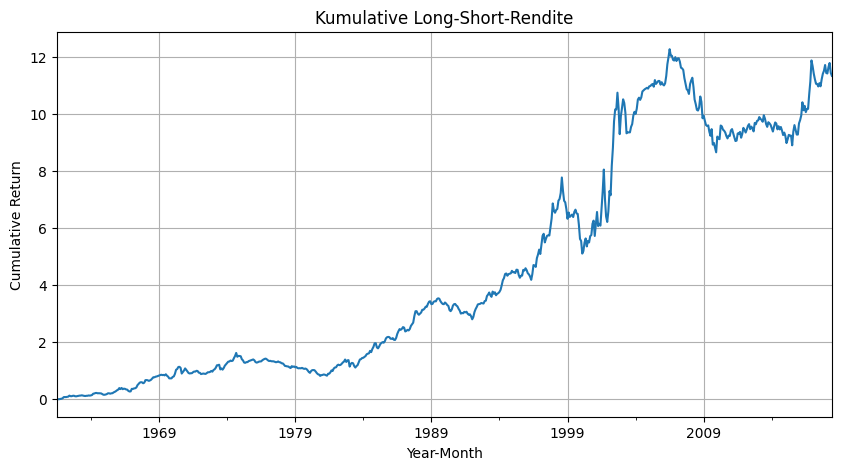

In [112]:
long_short_returns = []
bm_dec.index = pd.to_datetime(bm_dec.index, format="%Y-%m")
#returns.index = pd.to_datetime(returns.index)
#returns.index = returns.index.to_period("M")
log_returns = []

price_long_ts = []
dividends_long_ts = []
bookvalue_long_ts = []
price_minus_long_ts = []
bookvalue_minus_long_ts = []
long_log_returns = []

price_short_ts = []
dividends_short_ts = []
bookvalue_short_ts = []
price_minus_short_ts = []
bookvalue_minus_short_ts = []
short_log_returns = []

portfolio_value_long = []
portfolio_value_short = []

top_permno_all = []
bottom_permno_all = []

long_ret = []
pb_long = []
pb_short = []
bv_pershare_short = []

for year in sorted(set(date.year for date in bm_dec.index)):
    date = pd.Timestamp(f"{year}-06")
    date_dec = pd.Timestamp(f"{year-1}-12")
    if date_dec not in bm_dec.index:
        continue

    #Only stocks which contain values for June of a year get selected. Later months are not considered -> no look-ahead bias
    clean_row = bm_dec.loc[date_dec].dropna().sort_values(ascending=False) 
    n = len(clean_row)
    if n == 0:
        continue

    k = int(n * 0.3)
    bottom_permnos = clean_row.iloc[:k].index.tolist() #Selects permnos with the lower B/M-ratios
    top_permnos = clean_row.iloc[-k:].index.tolist() #Selects permnos with the higher B/M-ratios

    top_permno_year = pd.DataFrame({"year": date, "permno": top_permnos}) 
    top_permno_all.append(top_permno_year)

    bottom_permno_year = pd.DataFrame({"year": date, "permno": bottom_permnos})
    bottom_permno_all.append(bottom_permno_year)

    #Since the dataset contains data upto December 2018 and the fiscal year begins in June the loop would try to access data in 2019
    if year == 2018:
        continue 

    # Timeframe: July-June
    month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
    month_range = month_range.to_period('M')

    #Portfolio Weighted Market Capitalization: P_t- 
    target_date = f"{year + 1}-06"  # this should match the index format in price
    top_date = pd.to_datetime(target_date)
    df['date'] = pd.to_datetime(df['date'])


    #Market Capitalization
       
    # Step 1: Filter df to get shares outstanding for the relevant date and permnos
    shrout_filtered_m_long = df[(df['date'] == top_date) & (df['permno'].isin(top_permnos))]
    shrout_filtered_m_short = df[(df['date'] == top_date) & (df['permno'].isin(bottom_permnos))]
    # Step 2: Pivot so we get a Series indexed by permno, with shrout as values
    shrout_series_m_long = shrout_filtered_m_long.set_index('permno')['adj_shrout']
    shrout_series_m_short = shrout_filtered_m_short.set_index('permno')['adj_shrout']
    # Step 3: Get the matching prices and multiply
    bottom_m_prc = price.loc[target_date, price.columns.intersection(bottom_permnos)].dropna()
    top_m_prc = price.loc[target_date, price.columns.intersection(top_permnos)].dropna()
    # Ensure both Series are aligned
    sharesoutstanding_m_long = shrout_series_m_long.reindex(top_m_prc.index)
    sharesoutstanding_m_short = shrout_series_m_short.reindex(bottom_m_prc.index)
    # Step 4: Multiply
    long_m_prc = top_m_prc * sharesoutstanding_m_long
    short_m_prc = bottom_m_prc * sharesoutstanding_m_short

    #top_m_prc = price.loc[(f"{year + 1}-06"), price.columns.intersection(top_permnos)].dropna() * sharesoutstandint
    #bottom_m_prc = price.loc[(f"{year + 1}-06"), price.columns.intersection(bottom_permnos)].dropna()
    price_minus_long_ts.append({"date" : top_date, "avg_value" : sum(long_m_prc)})
    price_minus_short_ts.append({"date" : top_date, "avg_value" :sum(short_m_prc)})

    #Portfolio Weighted Book Value
    top_m_bv = bookvalue.loc[(f"{year + 1}-06"), bookvalue.columns.intersection(top_permnos)].dropna()
    bottom_m_bv = bookvalue.loc[(f"{year + 1}-06"), bookvalue.columns.intersection(bottom_permnos)].dropna()
    bookvalue_minus_long_ts.append({"date" : f"{year + 1}-06", "avg_value" : sum(top_m_bv)})
    bookvalue_minus_short_ts.append({"date" : f"{year + 1}-06", "avg_value" : sum(bottom_m_bv)})

    #Annual log-returns
    log_top_rets = annual_log_returns.loc[(f"{year}-06"), annual_log_returns.columns.intersection(top_permnos)].dropna()
    log_bottom_rets = annual_log_returns.loc[(f"{year}-06"), annual_log_returns.columns.intersection(bottom_permnos)].dropna()

    long_log_returns.append({"date" : f"{year}-06", "avg_value" :sum(log_top_rets)/len(log_top_rets)})
    short_log_returns.append({"date" : f"{year}-06", "avg_value" :sum(log_bottom_rets)/len(log_bottom_rets)})

    for m in month_range:
        #m = m.to_period("M")
        if m not in returns.index:
            print("m not in returns.index")
            continue
        
        top_rets = returns.loc[m, returns.columns.intersection(top_permnos)]
        bottom_rets = returns.loc[m, returns.columns.intersection(bottom_permnos)]

        #Portfolio weighted market capitalization       
        # Step 1: Filter df to get shares outstanding for the relevant date and permnos
        shrout_filtered_long = df[(df['date'] == m.to_timestamp()) & (df['permno'].isin(top_permnos))]
        shrout_filtered_short = df[(df['date'] == m.to_timestamp()) & (df['permno'].isin(bottom_permnos))]
        # Step 2: Pivot so we get a Series indexed by permno, with shrout as values
        shrout_series_long = shrout_filtered_long.set_index('permno')['adj_shrout']
        shrout_series_short = shrout_filtered_short.set_index('permno')['adj_shrout']
        # Step 3: Get the matching prices and multiply
        bottom_prc = price.loc[m, price.columns.intersection(bottom_permnos)].dropna()
        top_prc = price.loc[m, price.columns.intersection(top_permnos)].dropna()
        # Ensure both Series are aligned
        sharesoutstanding_long = shrout_series_long.reindex(top_prc.index) *1000
        sharesoutstanding_short = shrout_series_short.reindex(bottom_prc.index) *1000
        # Step 4: Multiply
        long_prc = top_prc * sharesoutstanding_long
        short_prc = bottom_prc * sharesoutstanding_short
        #top_prc = price.loc[m, price.columns.intersection(top_permnos)].dropna()
        #bottom_prc = price.loc[m, price.columns.intersection(bottom_permnos)].dropna()
        
        #Dividends
        top_div = dividends.loc[m, dividends.columns.intersection(top_permnos)].dropna()
        bottom_div = dividends.loc[m, dividends.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_div = shrout_series_short.reindex(bottom_div.index) *1000
        sharesoutstanding_long_div = shrout_series_long.reindex(top_div.index) *1000
        long_div = top_div * sharesoutstanding_long_div
        short_div = bottom_div * sharesoutstanding_short_div

        #Bookvalue
        top_bv = bookvalue.loc[m, bookvalue.columns.intersection(top_permnos)].dropna()
        bottom_bv = bookvalue.loc[m, bookvalue.columns.intersection(bottom_permnos)].dropna()
        
        pb_long.append({'date': m, 'pb_long' : long_prc.sum()/bottom_bv.sum()})
        pb_short.append({'date': m, 'pb_short': short_prc.sum()/top_bv.sum()})

        

        if top_rets.empty or bottom_rets.empty:
            continue

        avg_top = np.nanmean(top_rets)
        avg_bottom = np.nanmean(bottom_rets)
        spread = avg_top - avg_bottom

        long_short_returns.append((m, spread))
        long_ret.append({"date": m, "return": (top_prc/top_prc.shift(1))})

    price_long_ts.append({"date":m, "avg_value" : sum(long_prc)})
    dividends_long_ts.append({"date" : m, "avg_value" : sum(long_div)})
    bookvalue_long_ts.append({"date" : m, "avg_value" : sum(top_bv)})
    portfolio_value_long.append({"date" : m, "portfolio_value" : sum(long_prc)})

    price_short_ts.append({"date":m, "avg_value" : sum(short_prc)})
    dividends_short_ts.append({"date" : m, "avg_value" : sum(short_div)})
    bookvalue_short_ts.append({"date" : m, "avg_value" : sum(bottom_bv)})
    portfolio_value_short.append({"date" : m, "portfolio_value" : sum(short_prc)})

# Convert to DataFrame and set index
df_ls = pd.DataFrame(long_short_returns, columns=["date", "long_short_ret"])
#df_ls['date'] = pd.to_datetime(df_ls["date"])           # Step 1: Ensure datetime
df_ls.set_index("date", inplace=True)                   # Step 2: Set as index
#df_ls.index = df_ls.index.to_period('M')                # Step 3: Convert to PeriodIndex

# Calculate cumulative return
df_ls['cumret'] = (1 + df_ls['long_short_ret']).cumprod() - 1
df_ls['cumret'] = pd.to_numeric(df_ls['cumret'], errors='coerce')

# Plot
df_ls['cumret'].plot(title="Kumulative Long-Short-Rendite", figsize=(10, 5))
plt.ylabel("Cumulative Return")
plt.xlabel("Year-Month")
plt.grid(True)
plt.show()


In [113]:
clean_row

permno
14335    9.617375
91909    8.573141
10606    7.408982
87437    6.804470
86822    6.786995
           ...   
90288    0.003245
75342    0.003119
14607    0.002318
88871    0.001939
90527    0.000381
Name: 2017-12-01 00:00:00, Length: 2836, dtype: float64

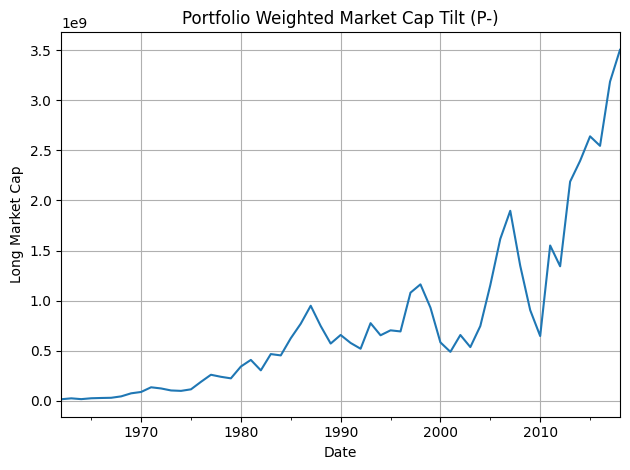

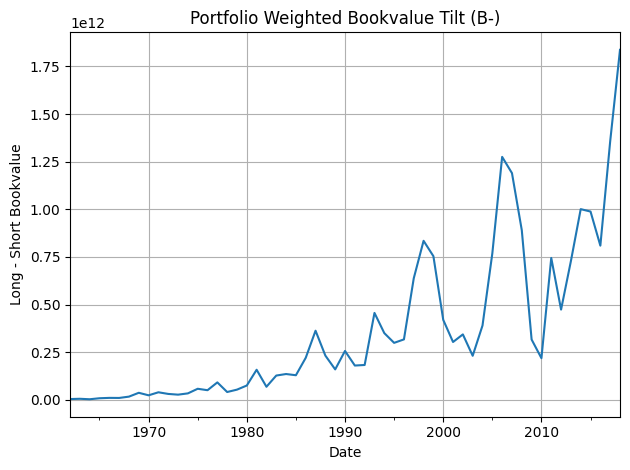

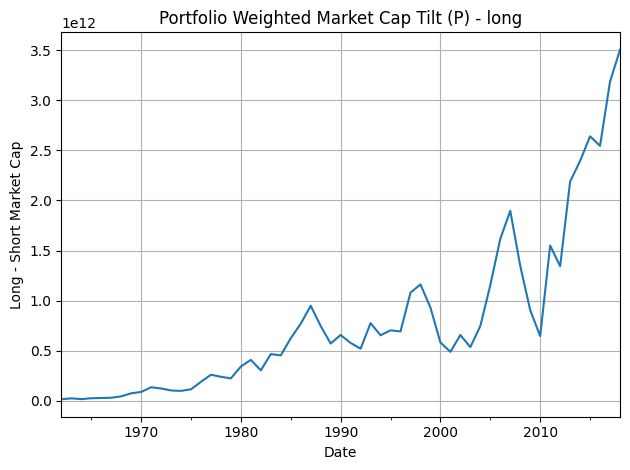

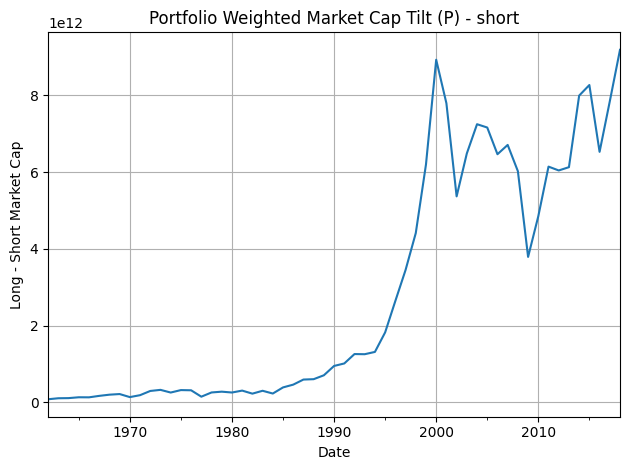

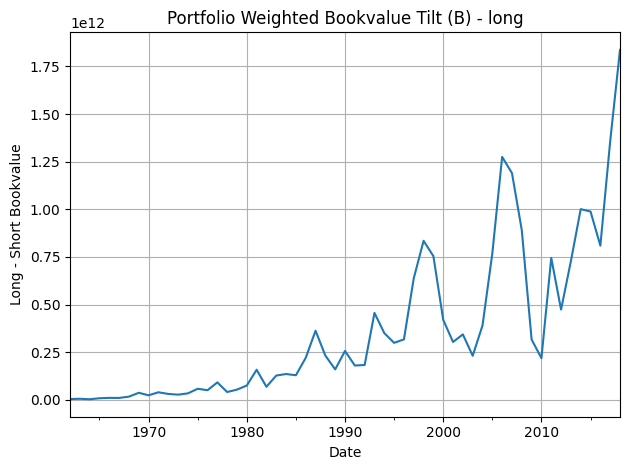

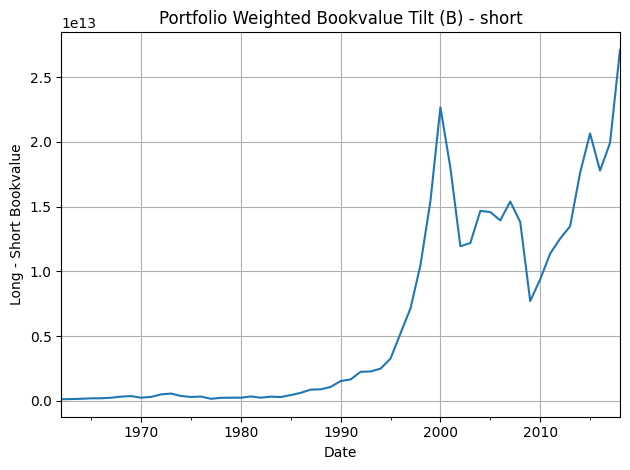

avg_value    1.120827e+11
dtype: float64


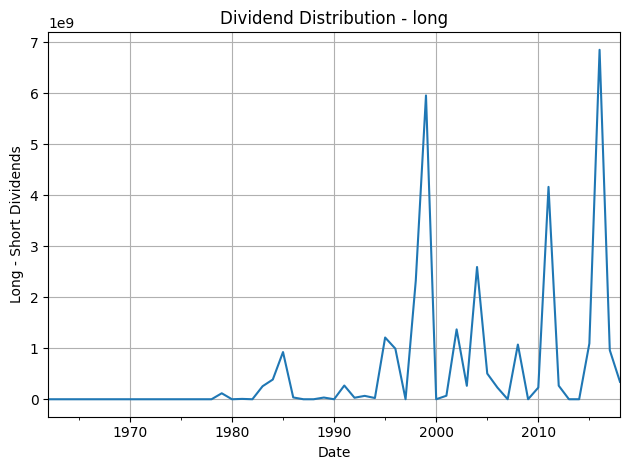

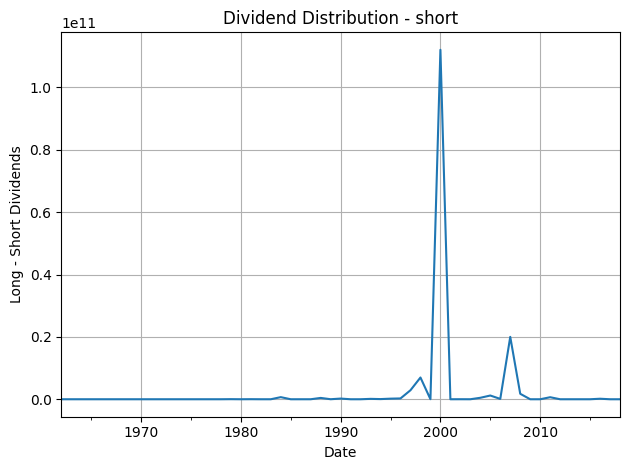

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_20467/1979398253.py:131: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  annual_returns = (1 + df_ls['long_short_ret']).resample('Y').prod() - 1


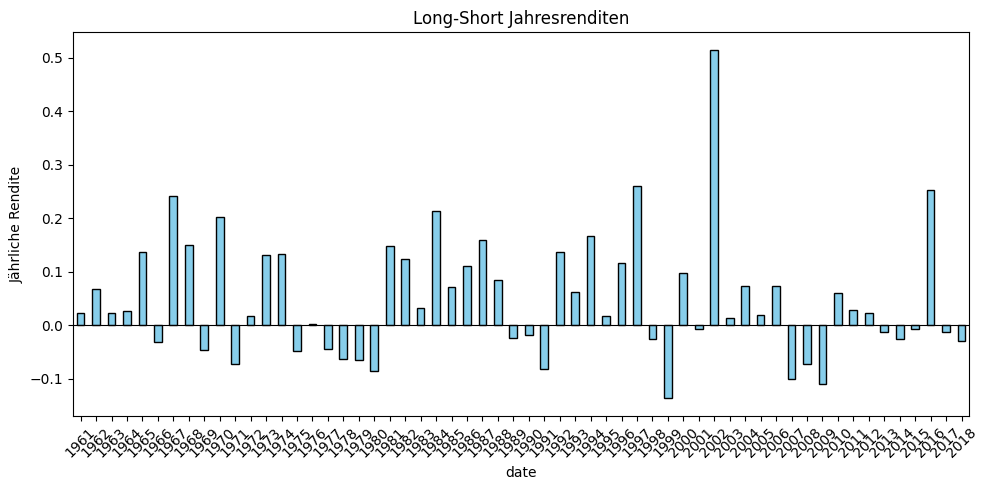

In [114]:
#DataFrame with all permnos over the years
df_top_permno_all = pd.concat(top_permno_all, ignore_index=True)
df_top_permno_all = df_top_permno_all.rename(columns={"year" : "date"})
#df_top_permno_all = df_top_permno_all.set_index("year", drop=True)

df_bottom_permno_all = pd.concat(bottom_permno_all, ignore_index=True)
df_bottom_permno_all = df_bottom_permno_all.rename(columns={"year" : "date"})
#df_bottom_permno_all = df_bottom_permno_all.set_index("year", drop=True)

#Portfolio Weighted Market Cap Tilt at time t for portfolios built at t-1 - long
df_price_minus_long_ts = pd.DataFrame(price_minus_long_ts)
df_price_minus_long_ts.set_index("date", inplace=True)
df_price_minus_long_ts.index = pd.to_datetime(df_price_minus_long_ts.index)

#Portfolio Weighted Market Cap Tilt at time t for portfolios built at t-1 - short
df_price_minus_short_ts = pd.DataFrame(price_minus_short_ts)
df_price_minus_short_ts.set_index("date", inplace=True)
df_price_minus_short_ts.index = pd.to_datetime(df_price_minus_short_ts.index)
#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
df_price_minus_long_ts.plot(title="Portfolio Weighted Market Cap Tilt (P-)", legend=False)
#df_price_minus_short_ts.plot()
plt.ylabel("Long Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()




#Portfolio Weighted Bookvalue at time t for portfolios built at t-1 - long
df_bookvalue_minus_long_ts = pd.DataFrame(bookvalue_minus_long_ts)
df_bookvalue_minus_long_ts.set_index("date", inplace=True)
df_bookvalue_minus_long_ts.index = pd.to_datetime(df_bookvalue_minus_long_ts.index)

#Portfolio Weighted Bookvalue at time t for portfolios built at t-1 - short
df_bookvalue_minus_short_ts = pd.DataFrame(bookvalue_minus_short_ts)
df_bookvalue_minus_short_ts.set_index("date", inplace=True)
df_bookvalue_minus_short_ts.index = pd.to_datetime(df_bookvalue_minus_short_ts.index)

#df_bookvalue_minus_ts.index = df_bookvalue_minus_ts.index.to_timestamp()
df_bookvalue_minus_long_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B-)", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

#Portfolio Weighted Market Cap Tilt (P) - long
df_price_long_ts = pd.DataFrame(price_long_ts)
df_price_long_ts.set_index("date", inplace=True)
df_price_long_ts.index = df_price_long_ts.index.to_timestamp()

#Portfolio Weighted Market Cap Tilt (P) - short
df_price_short_ts = pd.DataFrame(price_short_ts)
df_price_short_ts.set_index("date", inplace=True)
df_price_short_ts.index = df_price_short_ts.index.to_timestamp()

#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
df_price_long_ts.plot(title="Portfolio Weighted Market Cap Tilt (P) - long", legend=False)
plt.ylabel("Long - Short Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_price_short_ts.plot(title="Portfolio Weighted Market Cap Tilt (P) - short", legend=False)
plt.ylabel("Long - Short Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

#Portfolio Weighted Bookvalue - long
df_bookvalue_long_ts = pd.DataFrame(bookvalue_long_ts)
df_bookvalue_long_ts.set_index("date", inplace=True)
df_bookvalue_long_ts.index = df_bookvalue_long_ts.index.to_timestamp()

#Portfolio Weighted Bookvalue - short
df_bookvalue_short_ts = pd.DataFrame(bookvalue_short_ts)
df_bookvalue_short_ts.set_index("date", inplace=True)
df_bookvalue_short_ts.index = df_bookvalue_short_ts.index.to_timestamp()

#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
df_bookvalue_long_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B) - long", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_bookvalue_short_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B) - short", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

#Dividends - long
df_dividends_long_ts = pd.DataFrame(dividends_long_ts)
df_dividends_long_ts.set_index("date", inplace=True)
df_dividends_long_ts.index = df_dividends_long_ts.index.to_timestamp()

#Dividends - short
df_dividends_short_ts = pd.DataFrame(dividends_short_ts)
df_dividends_short_ts.set_index("date", inplace=True)
df_dividends_short_ts.index = df_dividends_short_ts.index.to_timestamp()

print(df_dividends_short_ts.max())

df_dividends_long_ts.plot(title="Dividend Distribution - long", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_dividends_short_ts.plot(title="Dividend Distribution - short", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


#Annual Log Returns
#df_ls['date'] = pd.to_datetime(df_ls['date'])
#df_ls = df_ls.set_index('date')

# Group by year, dann kumulierte Rendite berechnen
annual_returns = (1 + df_ls['long_short_ret']).resample('Y').prod() - 1
annual_returns.index = annual_returns.index.year  # Nur das Jahr anzeigen

#Annual log-returns to DataFrame
df_annual_log_returns_long_ts = pd.DataFrame(long_log_returns)
df_annual_log_returns_long_ts.set_index("date", inplace=True)
df_annual_log_returns_long_ts.index = pd.to_datetime(df_annual_log_returns_long_ts.index)

df_annual_log_returns_short_ts = pd.DataFrame(short_log_returns)
df_annual_log_returns_short_ts.set_index("date", inplace=True)
df_annual_log_returns_short_ts.index = pd.to_datetime(df_annual_log_returns_short_ts.index)

plt.figure(figsize=(10, 5))
annual_returns.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Jährliche Rendite')
plt.title('Long-Short Jahresrenditen')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_portfolio_value_long = pd.DataFrame(portfolio_value_long)
df_portfolio_value_long.set_index("date", inplace=True)
df_portfolio_value_long.index = df_portfolio_value_long.index.to_timestamp()
df_portfolio_value_short = pd.DataFrame(portfolio_value_short)
df_portfolio_value_short.set_index("date", inplace=True)
df_portfolio_value_short.index = df_portfolio_value_short.index.to_timestamp()
# Ensure both are pandas Series and sorted
df_portfolio_value_long = df_portfolio_value_long.sort_index()
df_portfolio_value_short = df_portfolio_value_short.sort_index()

# Sicherstellen, dass alle Inputs Series mit korrektem Index sind
long_val = df_portfolio_value_long.squeeze()
long_div = df_dividends_long_ts.squeeze()
short_val = df_portfolio_value_short.squeeze()
short_div = df_dividends_short_ts.squeeze()

# Index angleichen (falls nötig)
long_div = long_div.reindex_like(long_val).fillna(0)
short_div = short_div.reindex_like(short_val).fillna(0)

# Log-Returns berechnen
log_ret_long = np.log(long_val + long_div) - np.log((long_val).shift(1))
log_ret_short = np.log(short_val + short_div) - np.log((short_val).shift(1))

# Portfolio-Log-Return: Long - Short
portfolio_log_returns = log_ret_long - log_ret_short
 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Make sure all relevant columns are numeric
df_bookvalue_long_ts = df_bookvalue_long_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.apply(pd.to_numeric, errors='coerce')
df_price_long_ts = df_price_long_ts.apply(pd.to_numeric, errors='coerce')
df_price_minus_long_ts = df_price_minus_long_ts.apply(pd.to_numeric, errors='coerce')
df_dividends_long_ts = df_dividends_long_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_short_ts = df_bookvalue_short_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.apply(pd.to_numeric, errors='coerce')
df_price_short_ts = df_price_short_ts.apply(pd.to_numeric, errors='coerce')
df_price_minus_short_ts = df_price_minus_short_ts.apply(pd.to_numeric, errors='coerce')
df_dividends_short_ts = df_dividends_short_ts.apply(pd.to_numeric, errors='coerce')

# Align indexes if needed
common_index = df_bookvalue_long_ts.index.intersection(df_price_long_ts.index)
df_bookvalue_long_ts = df_bookvalue_long_ts.loc[common_index]
df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.loc[common_index]
df_price_long_ts = df_price_long_ts.loc[common_index]
df_price_minus_long_ts = df_price_minus_long_ts.loc[common_index]
df_dividends_long_ts = df_dividends_long_ts.loc[common_index]
common_index = df_bookvalue_short_ts.index.intersection(df_price_short_ts.index)
df_bookvalue_short_ts = df_bookvalue_short_ts.loc[common_index]
df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.loc[common_index]
df_price_short_ts = df_price_short_ts.loc[common_index]
df_price_minus_short_ts = df_price_minus_short_ts.loc[common_index]
df_dividends_short_ts = df_dividends_short_ts.loc[common_index]

# Filter zero or negative values to avoid log issues
valid = (df_bookvalue_long_ts.shift(1) > 0) & (df_price_minus_long_ts > 0)
valid &= df_bookvalue_minus_long_ts > 0
valid &= df_price_long_ts > 0
valid &= df_bookvalue_long_ts > 0

valid = (df_bookvalue_short_ts.shift(1) > 0) & (df_price_minus_short_ts > 0)
valid &= df_bookvalue_minus_short_ts > 0
valid &= df_price_short_ts > 0
valid &= df_bookvalue_short_ts > 0

#Return to Value
#annual_log_return =df_annual_log_returns_long_ts - df_annual_log_returns_short_ts

#Return to Value in three components
#change_in_aggregate_valuation_long = np.log(df_price_long_ts/df_bookvalue_long_ts)-np.log(df_price_long_ts.shift(1)/df_bookvalue_long_ts.shift(1))
#change_in_aggregate_valuation_short = np.log(df_price_short_ts/df_bookvalue_short_ts)-np.log(df_price_short_ts.shift(1)/df_bookvalue_short_ts.shift(1))
#income_yield = np.log(df_bookvalue_minus_ts/df_bookvalue_ts.shift(1))+np.log(1+ df_dividends_ts/df_price_minus_ts)
#migration = np.log(df_price_minus_ts/df_bookvalue_minus_ts)-np.log(df_price_ts/df_bookvalue_ts)

# Income Yield long
#income_yield_long = np.log(df_bookvalue_minus_long_ts/df_bookvalue_long_ts.shift(1))+np.log(1+df_dividends_long_ts/df_price_minus_long_ts)
# Income Yield short
#income_yield_short = np.log(df_bookvalue_minus_short_ts/df_bookvalue_short_ts.shift(1))+np.log(1+df_dividends_short_ts/df_price_minus_short_ts)

#Migration long
#migration_long = np.log(df_price_minus_long_ts/df_bookvalue_minus_long_ts)-np.log(df_price_long_ts/df_bookvalue_long_ts)
#Migration short
#migration_short = np.log(df_price_minus_short_ts/df_bookvalue_minus_short_ts)-np.log(df_price_short_ts/df_bookvalue_short_ts)



#revaluation_component_long = change_in_aggregate_valuation_long
#structural_component_long = income_yield_long + migration_long

#revaluation_component_short = change_in_aggregate_valuation_short
#structural_component_short = income_yield_short + migration_short

#return_decomposition_long = revaluation_component_long + structural_component_long
#return_decomposition_short = revaluation_component_short + structural_component_short

#return_decomposition = return_decomposition_long - return_decomposition_short



In [120]:
#PB-long
pb_long_series = pd.Series(pb_long)
pb_short_series = pd.Series(pb_short)
pd.to_pickle(pb_long_series, "pb_long.pkl")


In [43]:
df

,permno,date,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,...,yyyymm,BM,adj_price,adj_shrout,adj_dividend,market_equity,book_equity,log_ret,fiscal_year,dividend_yield
0,10000,1987-04-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,198704,-2.895161,0.234375,3893.0,NaN,9.124219e+05,2.641608e+06,-0.064539,1986,NaN
1,10000,1987-05-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,198705,-2.895161,0.218750,3893.0,NaN,8.515938e+05,2.465501e+06,-0.068993,1986,NaN
2,10001,1986-12-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,198612,-0.104958,2.333333,2973.0,NaN,6.937000e+06,7.280916e+05,0.014889,1986,NaN
3,10001,1987-01-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,198701,-0.104958,2.250000,2973.0,NaN,6.689250e+06,7.020884e+05,-0.036368,1986,NaN
4,10001,1987-02-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,198702,-0.104958,2.083333,2973.0,NaN,6.193750e+06,6.500818e+05,-0.076961,1986,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466395,93436,2018-08-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,201808,-2.622768,301.660004,170593.0,NaN,5.146109e+10,1.349705e+11,0.011737,2018,NaN
2466396,93436,2018-09-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,201809,-2.622768,264.769989,171578.0,NaN,4.542871e+10,1.191490e+11,-0.130439,2018,NaN
2466397,93436,2018-10-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,201810,-2.622768,337.320007,171733.0,NaN,5.792898e+10,1.519343e+11,0.242171,2018,NaN
2466398,93436,2018-11-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,201811,-2.622768,350.480011,171733.0,NaN,6.018898e+10,1.578618e+11,0.038272,2018,NaN


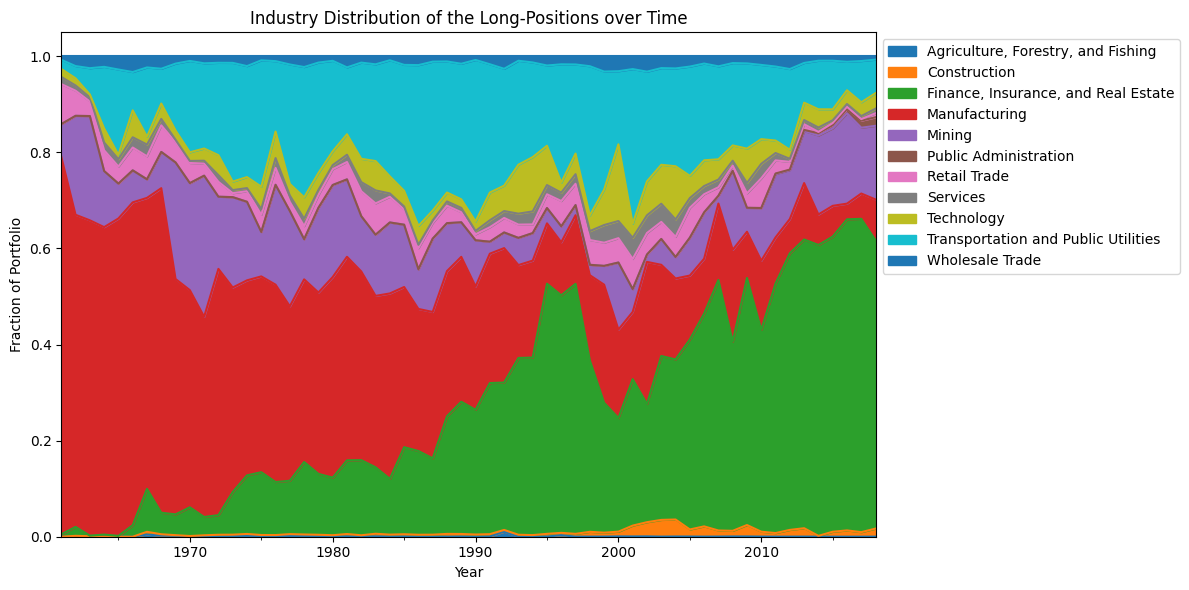

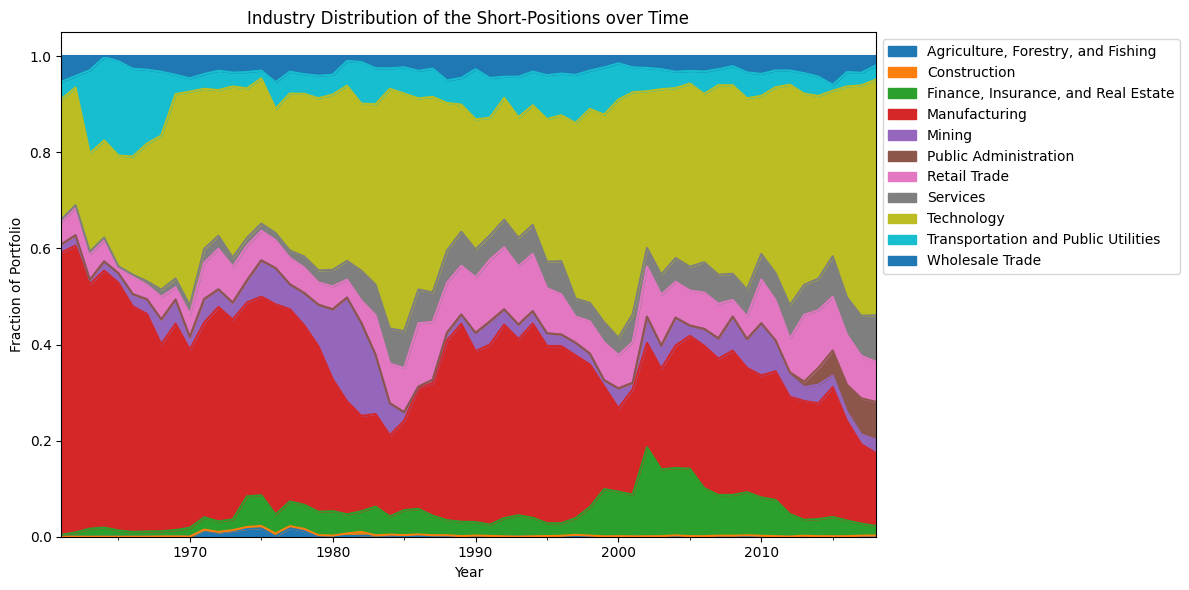

In [48]:
#Industry Analysis and HHI
df_industry_short = df.merge(df_top_permno_all, on=["date", "permno"], how="inner")
df_industry_long = df.merge(df_bottom_permno_all, on=["date", "permno"], how="inner")
df_industry_long = df_industry_long.dropna(subset=["hsiccd"])
df_industry_short = df_industry_short.dropna(subset=["hsiccd"])


def map_sic_to_sector(sic):
    sic_str = str(int(sic)).zfill(4)
    sic2 = int(sic_str[:2])

    technology_ranges = [
        (3570, 3579),  # Computer and Office equipment
        (3600, 3699),  # Electronics
        (7370, 7379),  # Software-Services
        (2830, 2839),  # Tech/Health
    ]

    sic4 = int(sic_str) 

    for start, end in technology_ranges:
        if start <= sic4 <= end:
            return "Technology"

    if 1 <= sic2 <= 9:
        return "Agriculture, Forestry, and Fishing"
    elif 10 <= sic2 <= 14:
        return "Mining"
    elif 15 <= sic2 <= 17:
        return "Construction"
    elif 20 <= sic2 <= 39:
        return "Manufacturing"
    elif 40 <= sic2 <= 49:
        return "Transportation and Public Utilities"
    elif 50 <= sic2 <= 51:
        return "Wholesale Trade"
    elif 52 <= sic2 <= 59:
        return "Retail Trade"
    elif 60 <= sic2 <= 67:
        return "Finance, Insurance, and Real Estate"
    elif 70 <= sic2 <= 89:
        return "Services"
    elif 90 <= sic2 <= 99:
        return "Public Administration"
    else:
        return "Other"


crsp = df.copy()
crsp['hsiccd'] = pd.to_numeric(crsp['hsiccd'], errors='coerce')  # convert to numeric, set errors to NaN
crsp = crsp.dropna(subset=['hsiccd'])  # remove rows with NaN SICCD

# Now safely convert to int
crsp['hsiccd'] = crsp['hsiccd'].astype(int)
crsp['industry'] = crsp['hsiccd'].apply(map_sic_to_sector)


df_industry_long["sector"] = df_industry_long["hsiccd"].apply(map_sic_to_sector)
grouped_long = df_industry_long.groupby(["date", "sector"])["market_equity"].sum().reset_index()
grouped_long["weight"] = grouped_long.groupby("date")["market_equity"].transform(lambda x: x / x.sum())

df_industry_short["sector"] = df_industry_short["hsiccd"].apply(map_sic_to_sector)
grouped_short = df_industry_short.groupby(["date", "sector"])["market_equity"].sum().reset_index()
grouped_short["weight"] = grouped_short.groupby("date")["market_equity"].transform(lambda x: x / x.sum())

pivot_df_long = grouped_long.pivot(index="date", columns="sector", values="weight")
pivot_df_short = grouped_short.pivot(index="date", columns="sector", values="weight")

pivot_df_long.plot.area(figsize=(12, 6))
plt.title("Industry Distribution of the Long-Positions over Time")
plt.ylabel("Fraction of Portfolio")
plt.xlabel("Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

pivot_df_short.plot.area(figsize=(12, 6))
plt.title("Industry Distribution of the Short-Positions over Time")
plt.ylabel("Fraction of Portfolio")
plt.xlabel("Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_20467/2381470393.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


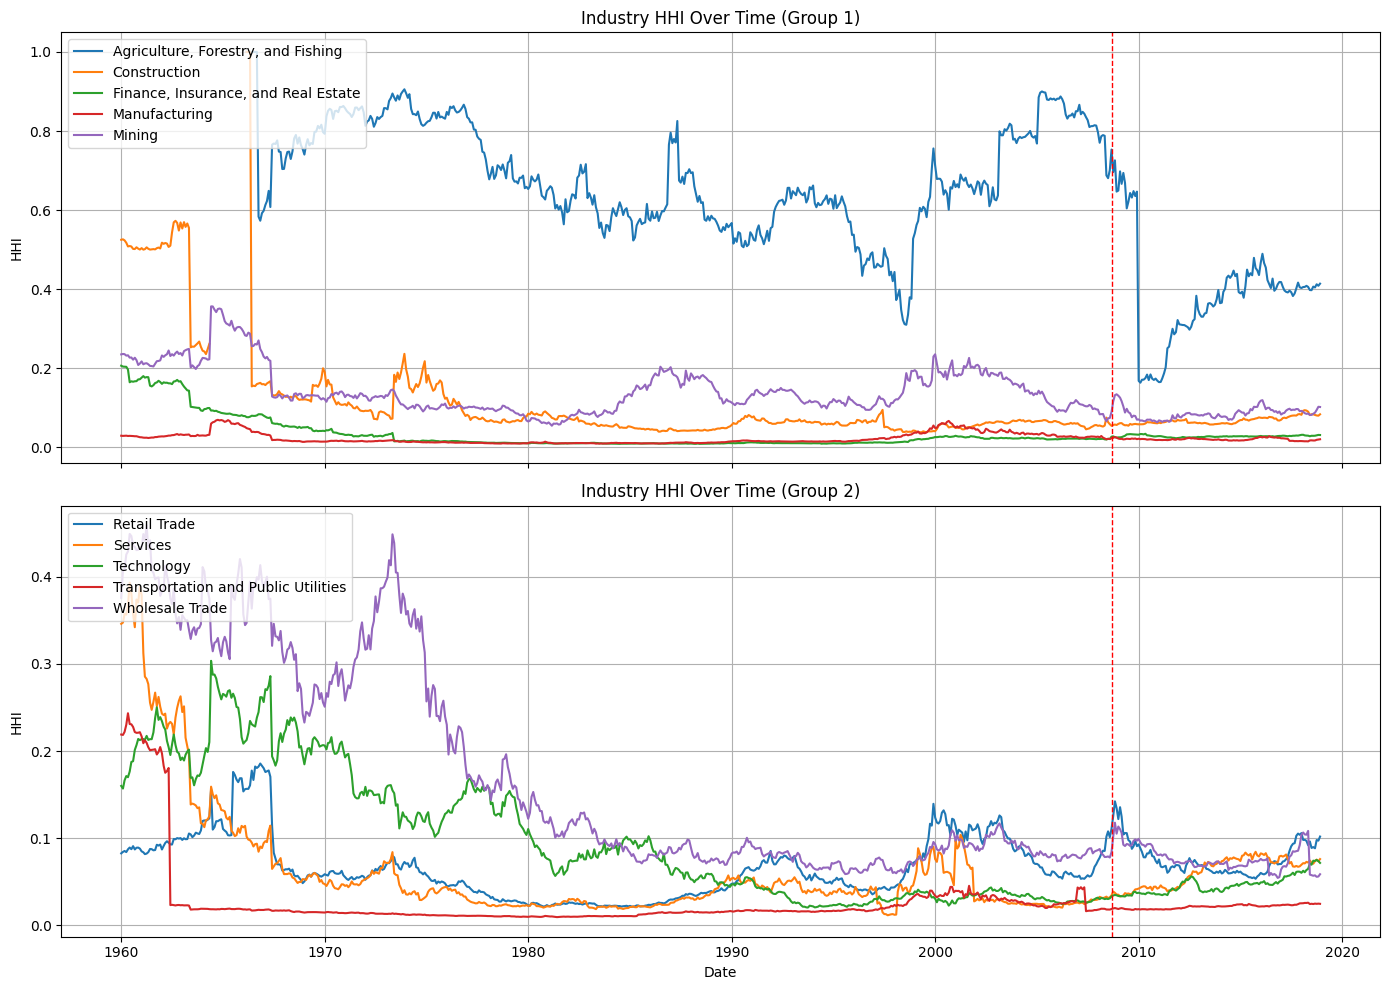

                               industry  HHI_compounded
0    Agriculture, Forestry, and Fishing     5806.432988
5                 Public Administration     1646.872227
4                                Mining      991.025855
10                      Wholesale Trade      626.782726
6                          Retail Trade      626.374102
1                          Construction      441.603136
7                              Services      330.590508
8                            Technology      271.037232
3                         Manufacturing      173.933608
2   Finance, Insurance, and Real Estate      170.921784
9   Transportation and Public Utilities      114.436516


In [91]:
#HHI computation
# 1. Clean market cap
crsp['adj_price'] = crsp['adj_price'].abs()
crsp['MktCap'] = crsp['adj_price'] * crsp['adj_shrout']
crsp['MktCap'] = crsp['MktCap'] * 100

# 2. Filter valid data
crsp = crsp.dropna(subset=['MktCap', 'hsiccd'])

hhi_by_industry = (
    crsp
    .groupby(['date', 'industry'])
    .apply(lambda g: pd.Series({
        'HHI': ((g['MktCap'] / g['MktCap'].sum()) ** 2).sum(),
        'Industry_MktCap': g['MktCap'].sum()
    }))
    .reset_index()
)

import matplotlib.pyplot as plt
import pandas as pd

# Pivot to time series
hhi_ts = hhi_by_industry.pivot(index='date', columns='industry', values='HHI')

# Remove 'Public Administration' if present
if 'Public Administration' in hhi_ts.columns:
    hhi_ts = hhi_ts.drop(columns='Public Administration')

# Split industries alphabetically into two balanced groups
industries = sorted(hhi_ts.columns)
mid = len(industries) // 2
group1 = industries[:mid]
group2 = industries[mid:]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Group 1
for col in group1:
    axes[0].plot(hhi_ts.index, hhi_ts[col], label=col)
axes[0].set_title('Industry HHI Over Time (Group 1)')
axes[0].set_ylabel('HHI')
axes[0].legend(loc='upper left')
axes[0].grid(True)
axes[0].axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', linewidth=1, label='Lehman Collapse')

# Plot Group 2
for col in group2:
    axes[1].plot(hhi_ts.index, hhi_ts[col], label=col)
axes[1].set_title('Industry HHI Over Time (Group 2)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('HHI')
axes[1].legend(loc='upper left')
axes[1].grid(True)
axes[1].axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

hhi_compounded = (
    crsp
    .groupby(['industry', 'permno'])['MktCap']
    .sum()
    .groupby(level=0)
    .apply(lambda x: (((x / x.sum())*100) ** 2).sum())
    .reset_index(name='HHI_compounded')
)

# Sort for easy comparison
hhi_compounded = hhi_compounded.sort_values('HHI_compounded', ascending=False)
print(hhi_compounded)

In [87]:
#ETF Trading Volume
import yfinance as yf

spy = yf.download("SPY", start="1960-01-01", end="2018-12-31", interval='1mo')
spy_volume = spy['Volume']

stock_data = crsp[crsp['shrcd'].isin([10, 11])] 
stock_volume = stock_data.groupby('date')['vol'].sum()

volumes = pd.concat([spy_volume, stock_volume], axis=1, join='inner')
volumes.columns = ['spy_volume', 'stock_volume']
total_volume = volumes['spy_volume'] + volumes['stock_volume']

etf_share = (volumes['spy_volume'] / total_volume).dropna()
etf_share

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_20467/1634717591.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="1960-01-01", end="2018-12-31", interval='1mo')
[*********************100%***********************]  1 of 1 completed


1993-01-01    0.011129
1993-02-01    0.058266
1993-03-01    0.032372
1993-04-01    0.029605
1993-05-01    0.021531
                ...   
2018-08-01    0.714555
2018-09-01    0.708203
2018-10-01    0.810438
2018-11-01    0.775493
2018-12-01    0.837526
Freq: MS, Length: 312, dtype: float64

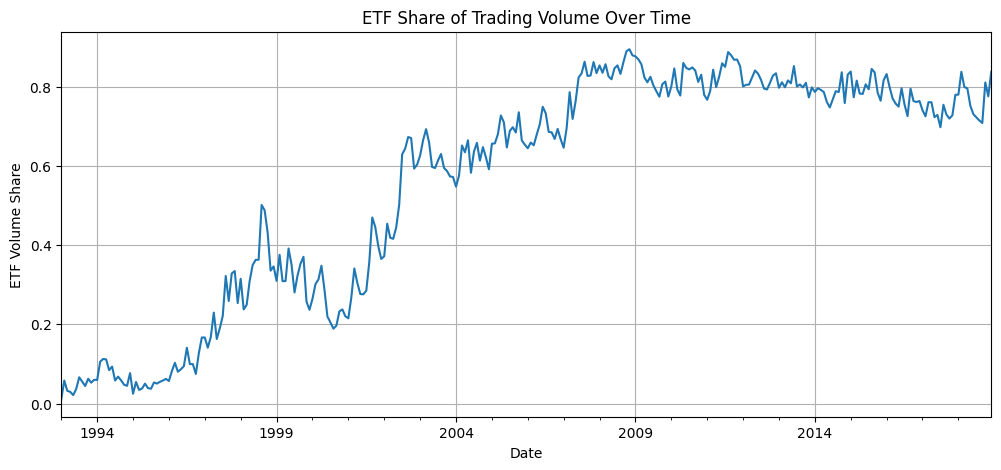

In [88]:
etf_share.plot(figsize=(12, 5), title='ETF Share of Trading Volume Over Time')
plt.xlabel("Date")
plt.ylabel("ETF Volume Share")
plt.grid(True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [35]:
#Outlier analysis of dividends
# Nur Zeilen aus den Jahren 2000 und 2001 auswählen
divs_2000 = dividends[dividends.index.year == 2000]
divs_2001 = dividends[dividends.index.year == 2001]

# Gesamtsumme pro Spalte im Jahr
sum_2000 = divs_2000.sum()
sum_2001 = divs_2001.sum()

q2000 = sum_2000.quantile(0.9999)
q2001 = sum_2001.quantile(0.9999)

# Spalten mit Dividenden über dem 75. Perzentil
high_2000 = sum_2000[sum_2000 > q2000].index
high_2001 = sum_2001[sum_2001 > q2001].index



#df.loc[df["permno"] == 48071, "dlamt"] = np.nan
#df.loc[df["permno"] == 82224, "dlamt"] = np.nan
#df.loc[df["permno"] == 86540, "dlamt"] = np.nan
high_2000



Index([48071, 82224, 86540], dtype='int64', name='permno')

In [36]:
# Apply NaN handling: fill where appropriate, avoid dividing by 0 or log(0)
eps = 1e-6  # Small value to avoid log(0)

#df_price_long_ts = df_price_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_long_ts = df_bookvalue_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_dividends_long_ts = df_dividends_long_ts.fillna(0)
#df_price_minus_long_ts = df_price_minus_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.replace(0, np.nan).fillna(method='ffill')

#df_price_short_ts = df_price_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_short_ts = df_bookvalue_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_dividends_short_ts = df_dividends_short_ts.fillna(0)
#df_price_minus_short_ts = df_price_minus_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.replace(0, np.nan).fillna(method='ffill')

# Revaluation component (change in P/B ratio)
change_in_aggregate_valuation_long = np.log((df_price_long_ts / df_bookvalue_long_ts + eps)) - \
                                     np.log((df_price_long_ts.shift(1) / df_bookvalue_long_ts.shift(1) + eps))

change_in_aggregate_valuation_short = np.log((df_price_short_ts / df_bookvalue_short_ts + eps)) - \
                                      np.log((df_price_short_ts.shift(1) / df_bookvalue_short_ts.shift(1) + eps))

# Income Yield
income_yield_long = np.log((df_bookvalue_minus_long_ts / df_bookvalue_long_ts.shift(1) + eps)) + \
                    np.log(1 + df_dividends_long_ts.shift(1) / df_price_minus_long_ts)

income_yield_short = np.log((df_bookvalue_minus_short_ts / df_bookvalue_short_ts.shift(1) + eps)) + \
                     np.log(1 + df_dividends_short_ts.shift(1) / df_price_minus_short_ts)

# Migration component
migration_long = np.log((df_price_minus_long_ts / df_bookvalue_minus_long_ts + eps)) - \
                 np.log((df_price_long_ts / df_bookvalue_long_ts + eps))

migration_short = np.log((df_price_minus_short_ts / df_bookvalue_minus_short_ts + eps)) - \
                  np.log((df_price_short_ts / df_bookvalue_short_ts + eps))

# Compose components
revaluation_component_long = change_in_aggregate_valuation_long
structural_component_long = (income_yield_long + migration_long)

revaluation_component_short = change_in_aggregate_valuation_short
structural_component_short = (income_yield_short + migration_short)

return_decomposition_long = revaluation_component_long + structural_component_long
return_decomposition_short = revaluation_component_short + structural_component_short

return_decomposition = return_decomposition_long - return_decomposition_short

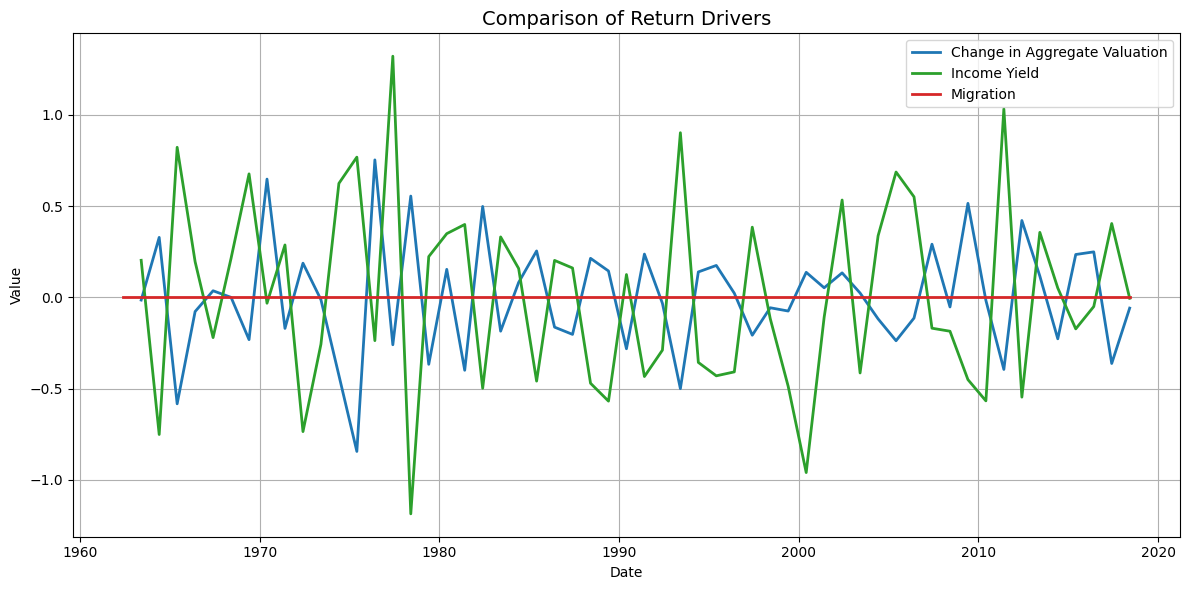

In [41]:
#Analysis of decomposed returns

change_in_aggregate_valuation = change_in_aggregate_valuation_long - change_in_aggregate_valuation_short
income_yield = income_yield_long - income_yield_short
migration = migration_long - migration_short

plt.figure(figsize=(12, 6))

plt.plot(change_in_aggregate_valuation.index, change_in_aggregate_valuation, label='Change in Aggregate Valuation', color='tab:blue', linewidth=2)
plt.plot(income_yield.index, income_yield, label='Income Yield', color='tab:green', linewidth=2)
plt.plot(migration.index, migration, label='Migration', color='tab:red', linewidth=2)

plt.title('Comparison of Return Drivers', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

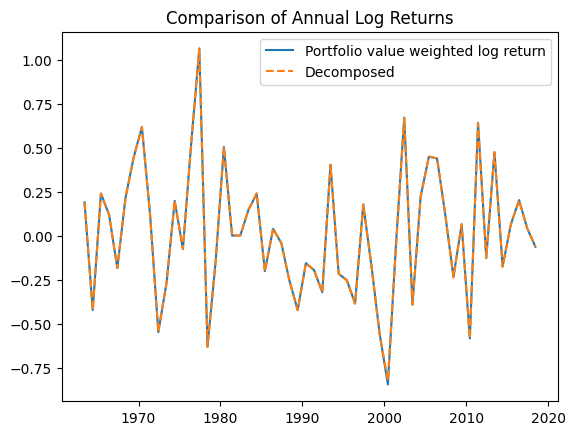

In [37]:
#Plot Return Comparios
plt.plot(portfolio_log_returns.index, portfolio_log_returns, label="Portfolio value weighted log return")
plt.plot(return_decomposition.index, return_decomposition, label="Decomposed", linestyle='--')
plt.legend()
plt.title("Comparison of Annual Log Returns")
plt.show()


The mistake that caused deviations between the original annual log return and the decomposed returns  (change in aggregate valuation, income yield and migration) was that the "normal" annualized log returns were value weighted while the decomposition was equally weighted. 

In [121]:
"""pd.to_pickle(df_ls["long_short_ret"], "long_short_returns.pkl")
pd.to_pickle(long_ret, "price_long.pkl")
pd.to_pickle(portfolio_log_returns, "ls_log_ret.pkl")
pd.to_pickle(hhi_by_industry, 'HHI.pkl')
pd.to_pickle(etf_share, 'etf_share.pkl')"""
pd.to_pickle(df_price_long_ts, "price_long.pkl")
"""pd.to_pickle(df_bookvalue_short_ts, "bv_short.pkl")
pd.to_pickle(df_dividends_short_ts, "div_short.pkl")

pd.to_pickle(df_bookvalue_long_ts, 'bv_long.pkl')
pd.to_pickle(df_dividends_long_ts, 'div_long.pkl')"""

'pd.to_pickle(df_bookvalue_short_ts, "bv_short.pkl")\npd.to_pickle(df_dividends_short_ts, "div_short.pkl")\n\npd.to_pickle(df_bookvalue_long_ts, \'bv_long.pkl\')\npd.to_pickle(df_dividends_long_ts, \'div_long.pkl\')'